<a href="https://colab.research.google.com/github/theabhinav0231/dive_into_deep_learning_book/blob/main/10_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

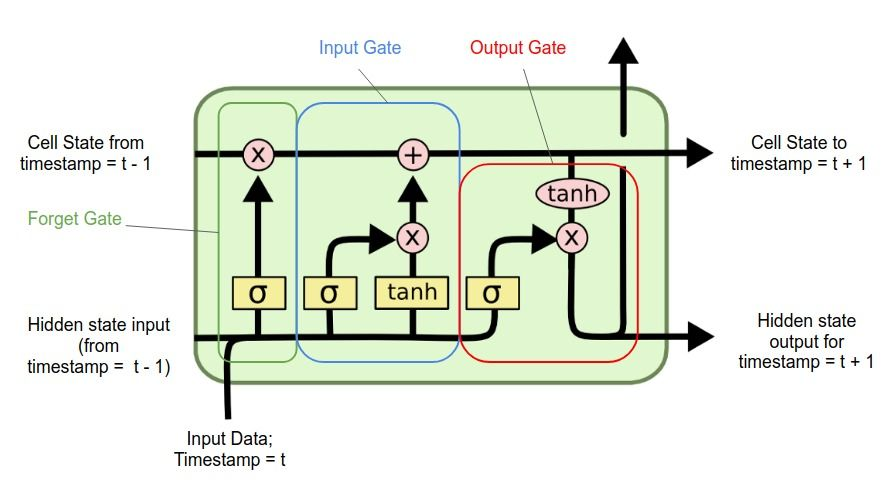

## **LSTM Implementation from Scratch**

In [4]:
class LSTMScratch(d2l.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
    triple = lambda: (init_weight(num_inputs, num_hiddens),
                      init_weight(num_hiddens, num_hiddens),
                      nn.Parameter(torch.zeros(num_hiddens)))

    self.W_xi, self.W_hi, self.b_i = triple() # Input gate
    self.W_xf, self.W_hf, self.b_f = triple() # Forget gate
    self.W_xo, self.W_ho, self.b_o = triple() # Output gate
    self.W_xc, self.W_hc, self.b_c = triple() # Intput node

  # Only the hidden state is passed to the output layer
  def forward(self, inputs, H_C=None):
    if H_C is None:
      # initial state with shape: (batch_size, num_hiddens)
      H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
      C = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
      H, C = H_C
    outputs = []
    for X in inputs:
      # input gate
      I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
      # foget gate
      F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
      # output gate
      O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
      # input candidate
      C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
      # cell state
      C = F * C + I * C_tilde
      # hidden state
      H = O * torch.tanh(C)
      outputs.append(H)
    return outputs, (H, C)

## **Training**

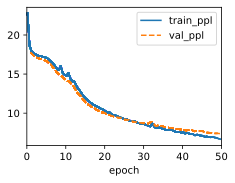

In [5]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [10]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

## **Concise Implementation**

In [11]:
class LSTM(d2l.RNN):
  def __init__(self, num_inputs, num_hiddens):
    d2l.Module.__init__(self)
    self.save_hyperparameters()
    self.rnn = nn.LSTM(num_inputs, num_hiddens)

  def forward(self, inputs, H_C=None):
    return self.rnn(inputs, H_C)

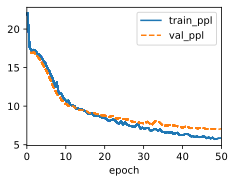

In [12]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [13]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has in the the the the '